In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

import numpy as np

In [2]:
sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

tqdm.pandas()

In [3]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

In [4]:
def article_profiles(dois:List, pattern:str="mentions_norm_mean", norm_refs=False, norm_eng=False, ax=None) -> None:
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    scores = {}
    for doi in tqdm(dois):
        pdf = citation_patterns[citation_patterns.target==doi].copy()
        pdf = pdf.sort_values(pattern)
        
        if norm_refs:
            pdf["x_perc"] = pdf[pattern].rank(method="first") - 1
            pdf["x_perc"] = pdf["x_perc"] / pdf["x_perc"].max()
        else:
            pdf["x_perc"] = pdf[pattern].rank(method="first")
            
        if norm_eng:
            pdf[pattern] = pdf[pattern] / pdf[pattern].max()
        
        sns.lineplot(data=pdf, x="x_perc", y=pattern, zorder=1, ax=ax)
        sns.scatterplot(data=pdf, x="x_perc", y=pattern, size="mentions", ax=ax,
                        sizes=(20,200), legend=False, zorder=2, palette="Set2")
        
    ax.set_title(f"{len(dois)} DOIs")
    ax.set_xlabel("Citing Articles")
    ax.set_ylabel("Relative Engagement");

## Load data

In [5]:
metadata = pd.read_csv(processed_dir / "contexts.csv", index_col="doi")
mention_patterns = pd.read_csv(processed_dir / "mention_patterns.csv", index_col=0)
citation_patterns = pd.read_csv(processed_dir / "citation_patterns.csv", index_col=0)
article_patterns = pd.read_csv(processed_dir / "article_patterns.csv", index_col=0)

In [6]:
article_patterns["age"] = 2021 - metadata.year

In [11]:
col_names = {
    "refs_agg": "Citation count",
    "mentions_agg": "Mention count",
    "refs_norm_agg": "Frac. citation count",
    "mentions_norm_agg": "Frac. mention count",
    "recite_1": "recitation_1",
    "recite_N": "recitation_N",
    "eng_norm_avg": "Avg rel engagement",
    "consistency": "Eng. consistency",
    "age": "Publication age"
}

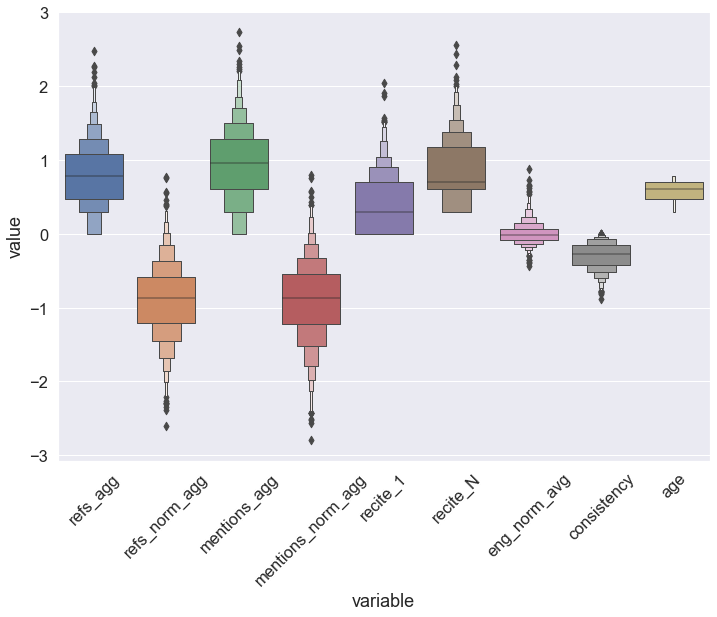

In [12]:
pdf = np.log10(article_patterns).melt()
sns.boxenplot(data=pdf, x="variable", y="value")
plt.xticks(rotation=45);

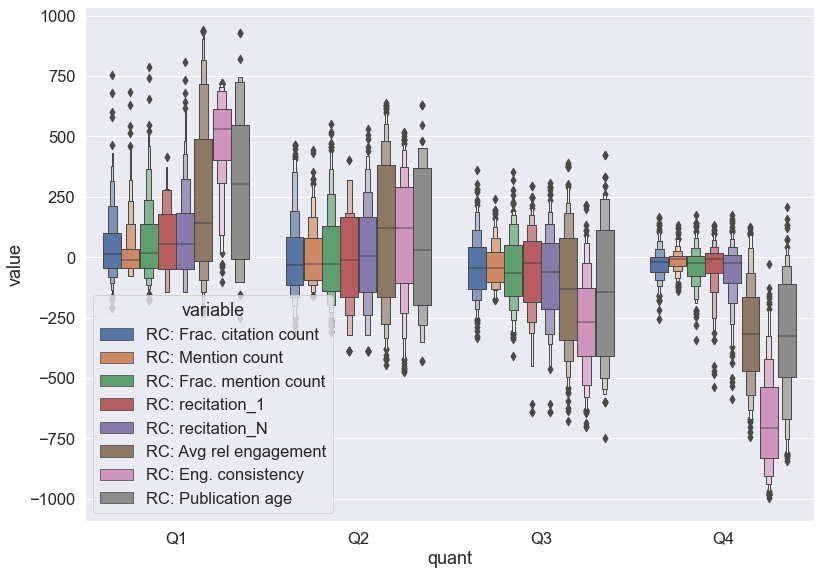

In [13]:
n_quantiles = 5
df = article_patterns.rename(columns=col_names)

base_var = col_names["refs_agg"]
count_methods = df.columns.tolist()
count_methods.remove(base_var)

df = df.rank()
for cm in count_methods:
    df["RC: " + cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index"], value_vars=["RC: " + cm for cm in count_methods])

sns.boxenplot(data=pdf, hue="variable", y="value", x="quant")
plt.tight_layout()

In [15]:
cmap = sns.light_palette("green", as_cmap=True)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr = (
    article_patterns
    .rename(columns=col_names)
    .corr(method="spearman")
)

corr.round(2)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# corr.style.background_gradient(cmap="vlag", low=corr.min().min())

,Citation count,Frac. citation count,Mention count,Frac. mention count,recitation_1,recitation_N,Avg rel engagement,Eng. consistency,Publication age
Citation count,1.00,0.89,0.93,0.85,0.83,0.77,0.24,-0.71,0.17
Frac. citation count,0.89,1.00,0.83,0.95,0.75,0.69,0.21,-0.60,0.21
Mention count,0.93,0.83,1.00,0.89,0.92,0.93,0.49,-0.81,0.14
Frac. mention count,0.85,0.95,0.89,1.00,0.82,0.82,0.44,-0.68,0.19
recitation_1,0.83,0.75,0.92,0.82,1.00,0.96,0.58,-0.71,0.10
recitation_N,0.77,0.69,0.93,0.82,0.96,1.00,0.69,-0.80,0.09
Avg rel engagement,0.24,0.21,0.49,0.44,0.58,0.69,1.00,-0.53,-0.02
Eng. consistency,-0.71,-0.60,-0.81,-0.68,-0.71,-0.80,-0.53,1.00,-0.12
Publication age,0.17,0.21,0.14,0.19,0.10,0.09,-0.02,-0.12,1.00


In [20]:
article_patterns

,refs_agg,refs_norm_agg,mentions_agg,mentions_norm_agg,recite_1,recite_N,eng_norm_avg,consistency,age
10.3389/fneur.2017.00535,6,0.091612,13,0.112119,3,10,1.347773,0.587056,4.0
10.1016/j.clinph.2018.04.747,3,0.091580,4,0.091926,1,2,1.000784,0.740572,3.0
10.3390/ijms18081638,18,0.352699,23,0.302883,5,10,0.925604,0.530720,4.0
10.1038/srep19230,15,0.306009,49,0.553040,8,42,1.656534,0.235366,5.0
10.1186/s13287-018-0890-5,4,0.127793,6,0.129791,2,4,1.190518,0.716494,3.0
...,...,...,...,...,...,...,...,...,...
10.2174/1570159x15666170102145257,3,0.070047,3,0.064526,0,0,0.902576,0.969760,4.0
10.1177/0306312715619783,4,0.198035,9,0.257914,3,8,1.323061,0.587949,6.0
10.3390/toxins10010006,2,0.023598,2,0.012950,0,0,0.588253,0.725322,4.0
10.1155/2017/3978595,5,0.066101,6,0.058921,1,2,0.965926,0.522249,4.0


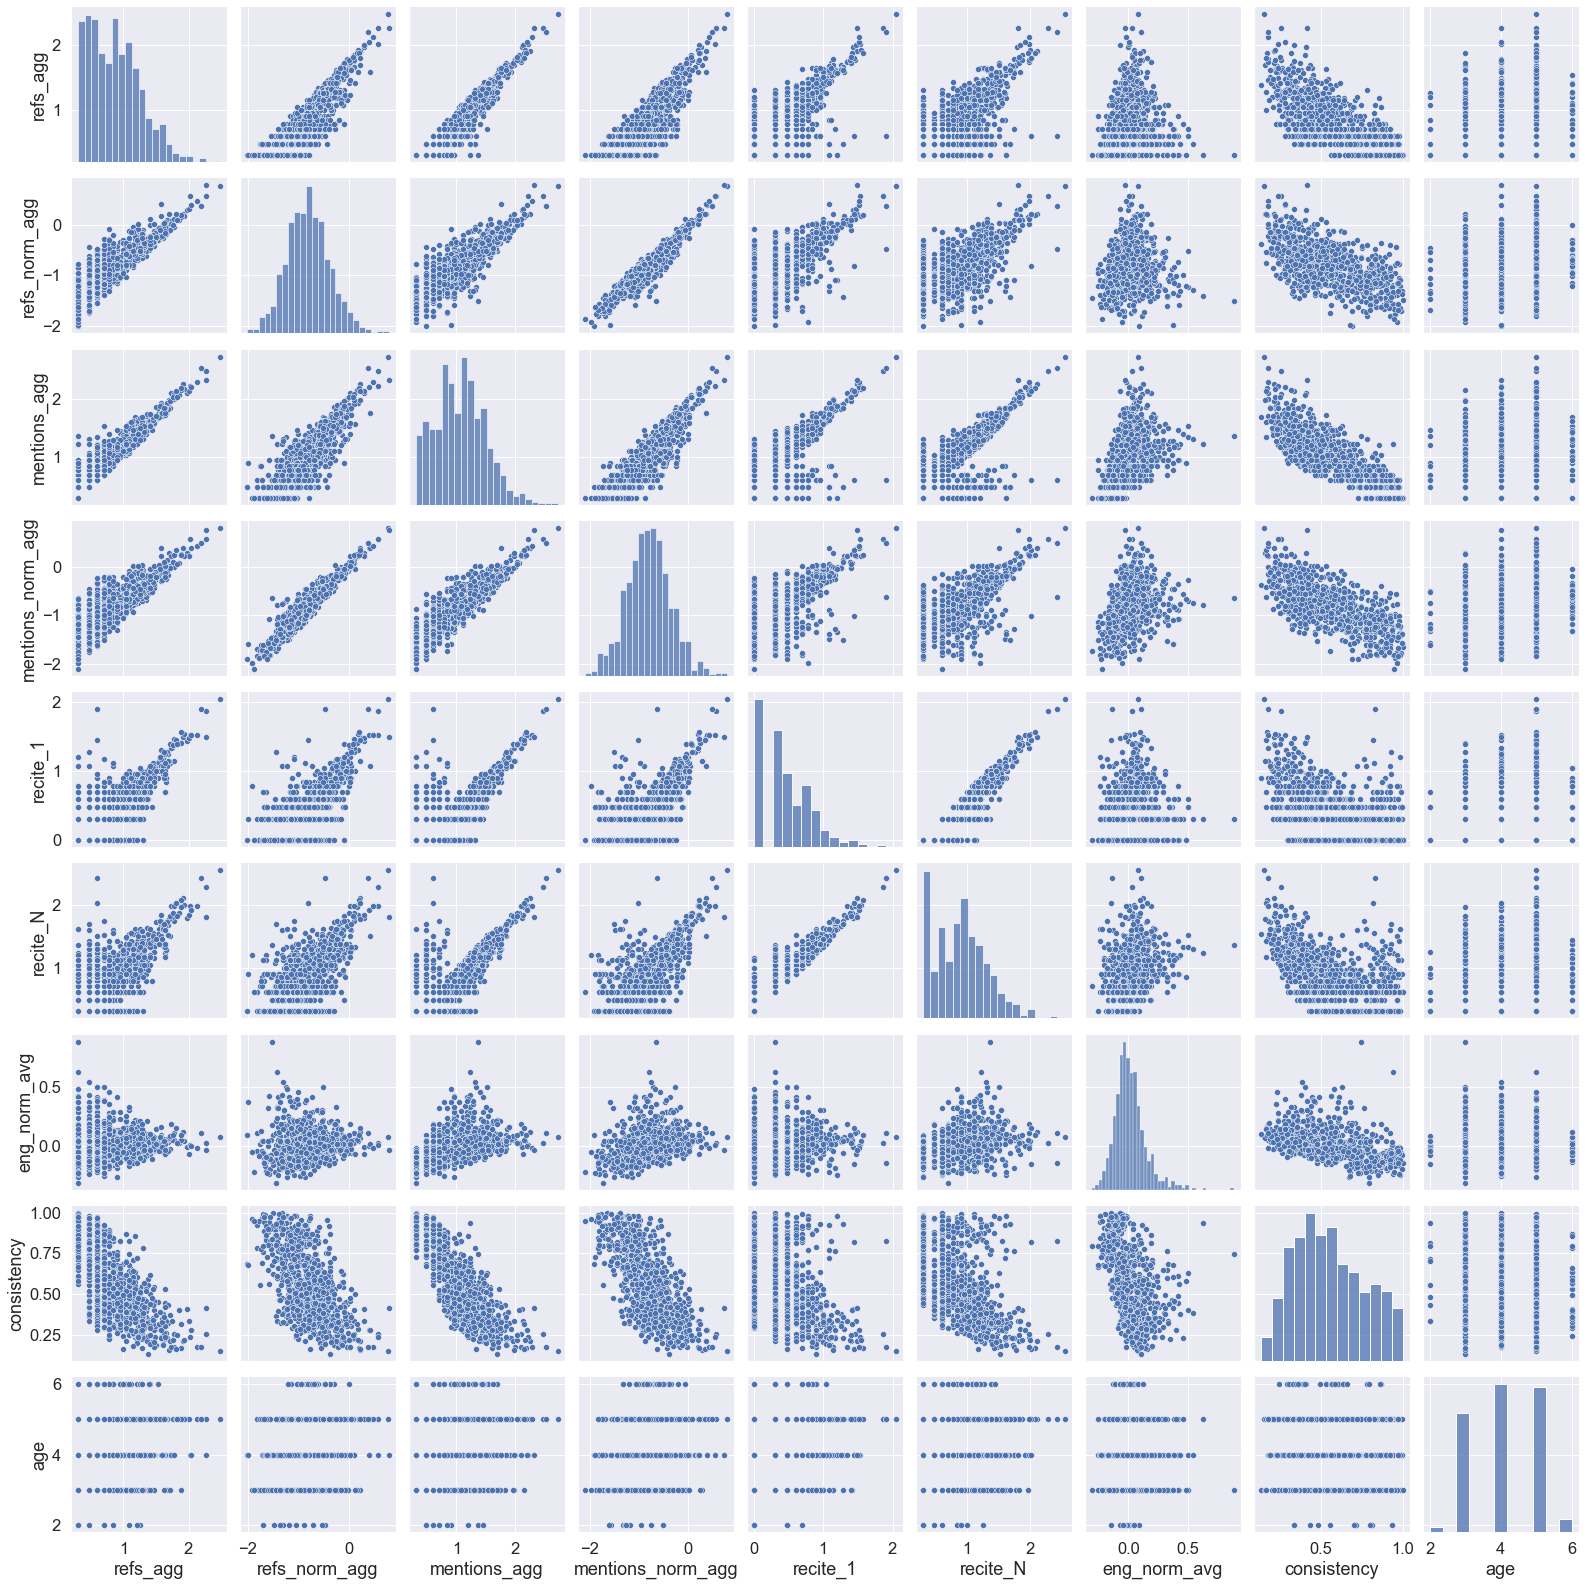

In [19]:
pdf = article_patterns.copy().replace(0, None).dropna()

log_cols = ["refs_agg", "mentions_agg", "refs_norm_agg", "mentions_norm_agg", "eng_norm_avg", "recite_1", "recite_N"]
for lc in log_cols:
    pdf[lc] = np.log10(pdf[lc])
g = sns.pairplot(pdf)

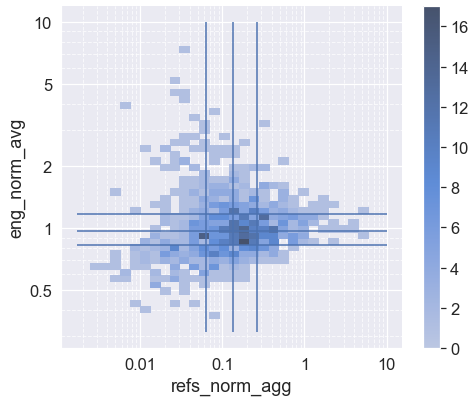

In [112]:
## Citations vs median weighted citation count
x = "refs_norm_agg"
y = "eng_norm_avg"

pdf = article_patterns
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

# Formatting
plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

xticks = [.01, .1, 1, 10]
plt.xticks(ticks=xticks, labels=xticks);

yticks = [.5, 1, 2, 5, 10]
plt.yticks(ticks=yticks, labels=yticks)

# plot percentiles
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1);

In [113]:
dois = article_patterns[
    (article_patterns.refs_agg>=10) &
    (article_patterns.eng_norm_avg>=.5)
].sample(5).index

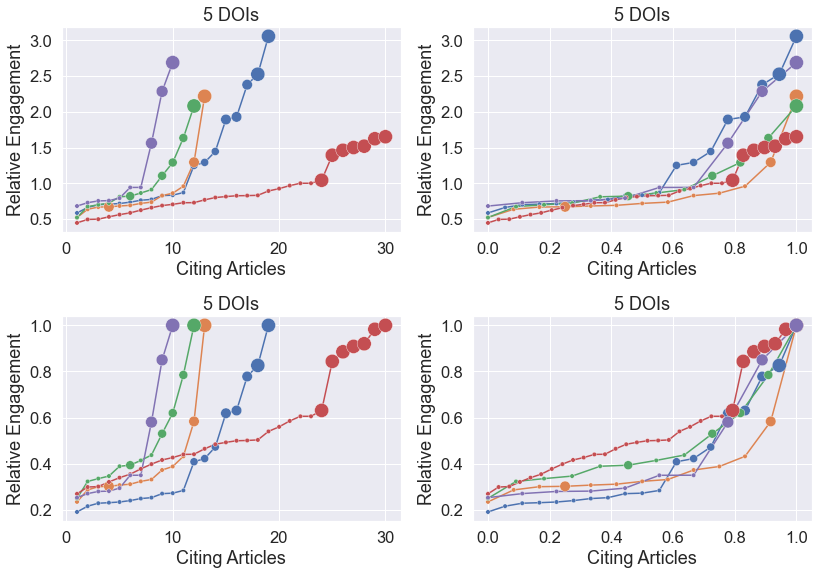

In [114]:
fig, axes = plt.subplots(2,2)

article_profiles(dois, norm_refs=False, ax=axes[0, 0])
article_profiles(dois, norm_refs=True, ax=axes[0, 1])
article_profiles(dois, norm_eng=True, ax=axes[1, 0])
article_profiles(dois, norm_refs=True, norm_eng=True, ax=axes[1, 1])

plt.tight_layout()

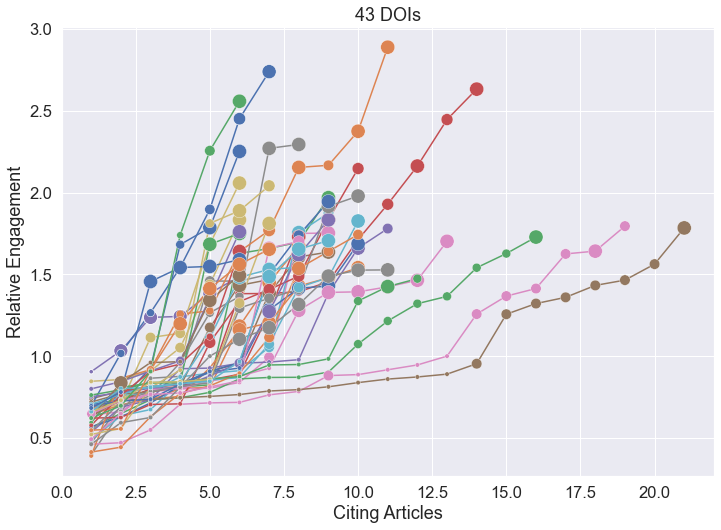

In [116]:
dois = article_patterns[
    (article_patterns.eng_norm_avg>=article_patterns.eng_norm_avg.quantile(.5)) &
    (article_patterns.refs_agg>=article_patterns.refs_agg.quantile(.5)) &
    (article_patterns.consistency>=article_patterns.consistency.quantile(.5))
].index

article_profiles(dois)

In [3]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"

# pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = article_patterns[article_patterns.refs_agg>=2]

sns.scatterplot(data=pdf,
                y=y,
                x=x,
                size="refs_agg",
                hue="consistency", sizes=(30, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

NameError: name 'article_patterns' is not defined

In [13]:
article_patterns.columns

Index(['refs_agg', 'mentions_agg', 'refs_norm_agg', 'eng_norm_avg', 'recite_1',
       'recite_N', 'consistency', 'age'],
      dtype='object')

In [20]:
article_patterns.columns.tolist().remove("refs_agg")

In [19]:
count_methods.remove(base_var)

AttributeError: 'NoneType' object has no attribute 'remove'